In [ ]:
"""
@author: hjooh
@date: 3.4.2025

Process:
1. Read and process data
2. Resample and aggregate index
3. Normalize values
4. Moving average
5. Plot
6. Exploratory techniques... SVM?
"""

In [3]:
import pandas as pd
import numpy as np
# use .2 seconds as or stdev of delta(t)
h1 = pd.read_csv("hallway1.csv")
h1 = h1.drop(columns=["events"])
h1

,time,wearable,soc,cvip,cpu,gpu,5v_sys,nvme_pwr1,nvme_pwr3,nvme_pwr2,...,THERM_TOT_PWR-throttle,Tboard_soc1tmp,Tdiode_soc1tmp,battery,chrgr,ddr1,ddr2,mem,mero2,vrm
0,time,power,power,power,power,power,power,power,power,power,...,power,thermal,thermal,thermal,thermal,thermal,thermal,thermal,thermal,thermal
1,0.003,5420000,1140000,1649000,731000,105000,6232000,79000,32000,11000,...,25000000,118.4,114.8,91.4,112.775,117.05,115.1366,110.4116,118.0616,115.25
2,0.204,5420000,1408000,2138000,1078000,5465000,6232000,10000,32000,11000,...,25000000,118.4,114.8,91.4,112.775,117.05,115.1366,110.4116,118.0616,115.25
3,0.402,5365000,1198000,1710000,751000,105000,6263000,20000,32000,11000,...,25000000,118.4,114.8,91.4,112.8866,117.1616,115.1366,110.4116,118.175,115.25
4,0.602,5365000,1309000,1378000,740000,105000,6263000,10000,32000,11000,...,25000000,118.4,114.8,91.4,112.8866,117.1616,115.1366,110.4116,118.175,115.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,100.403,5514000,1287000,1853000,928000,105000,6267000,20000,35000,11000,...,25000000,123.8,120.65,91.76,117.1616,122.45,120.65,113.5616,123.35,120.425
504,100.604,5514000,1162000,1948000,867000,105000,6311000,20000,78000,11000,...,25000000,123.8,120.65,91.58,117.1616,122.45,120.7616,113.5616,123.4616,120.425
505,100.802,5514000,1251000,2375000,847000,105000,6311000,10000,35000,11000,...,25000000,123.8,121.1,91.58,117.1616,122.45,120.7616,113.5616,123.4616,120.425
506,101.002,5374000,1251000,1948000,711000,105000,6311000,20000,78000,11000,...,25000000,123.8,120.65,91.58,117.1616,122.45,120.7616,113.5616,123.4616,120.425


In [4]:
def import_csv(name, path):
    dataframe = pd.read_csv(path)

    dataframe = dataframe.drop(columns=["events"])

    dataframe['time'] = pd.to_numeric(dataframe['time'], errors='coerce')
    dataframe['time'] = pd.to_datetime(dataframe['time'], unit='s', origin='unix')
    dataframe.set_index('time', inplace=True)

    dataframe = dataframe.iloc[1:]
    dataframe = dataframe.apply(pd.to_numeric, errors='coerce')
    
    return dataframe

In [ ]:
def resample(dataframe):
    dataframe = dataframe.sort_index()  
    
    # Resample to 1ms interval and fill missing values using forward fill (default choice for me tbh)
    dataframe_resampled = dataframe.resample('1ms').mean().interpolate(method='nearest')
    return dataframe_resampled


In [6]:
def normalize(dataframe):
    dataframe = (dataframe - dataframe.min()) / (dataframe.max() - dataframe.min())
    return dataframe

In [7]:
def moving_average(dataframe, window_size):
    if len(dataframe) < window_size:
        return -1
    
    rolling_avg = dataframe.rolling(window=window_size).mean()
    return rolling_avg


In [8]:
df = import_csv("hallway1", "hallway1.csv")
df = resample(df)
ma = moving_average(df,500)

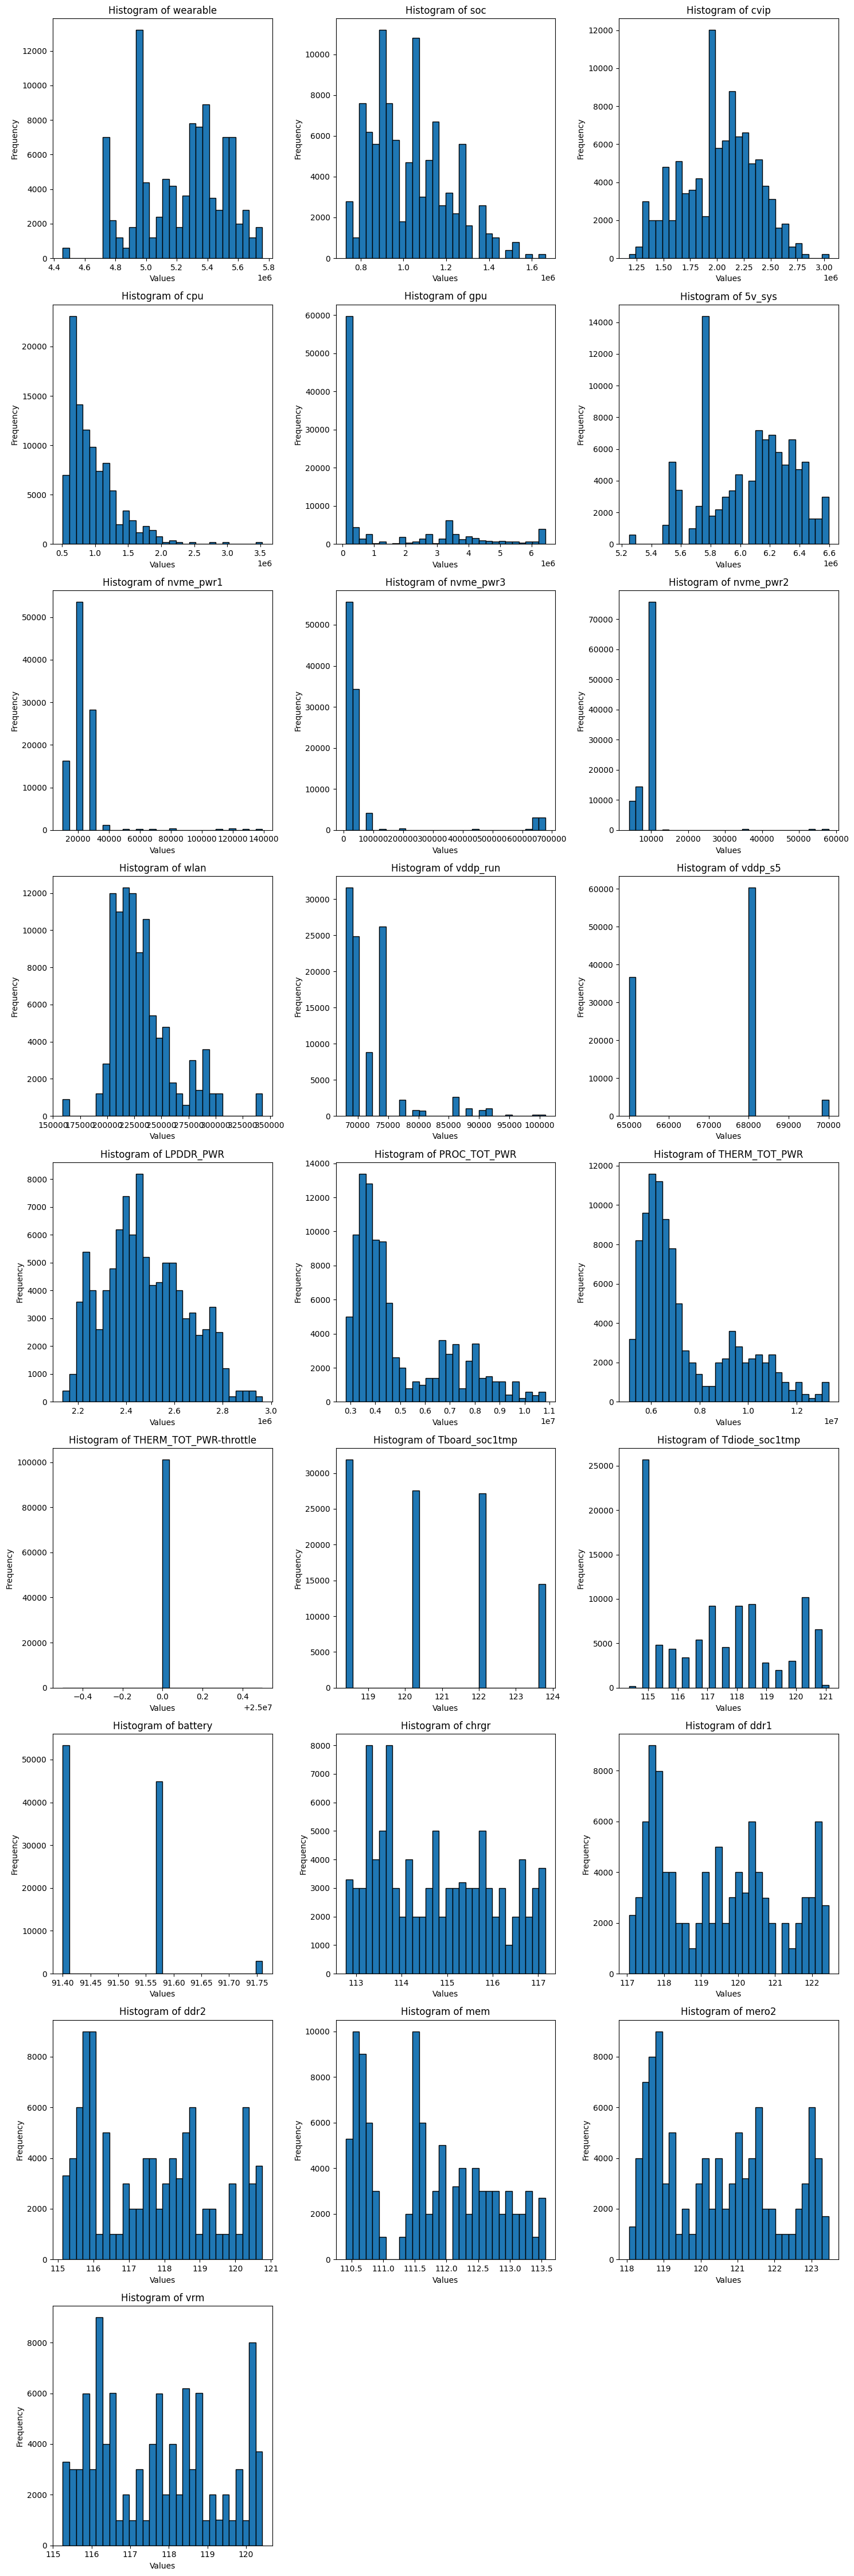

In [9]:
import matplotlib.pyplot as plt

num_columns = len(df.columns)
n_cols = 3  
n_rows = (num_columns // n_cols) + (num_columns % n_cols > 0)  
plt.figure(figsize=(15, 5 * n_rows))

for i, column in enumerate(df.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.hist(df[column].dropna(), bins=30, edgecolor='black') 
    plt.title(f'Histogram of {column}')
    plt.xlabel('Values')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [10]:
from sklearn.preprocessing import PowerTransformer

scaler = PowerTransformer(method='yeo-johnson')
df_scaled = scaler.fit_transform(df)

In [11]:
df_scaled = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)

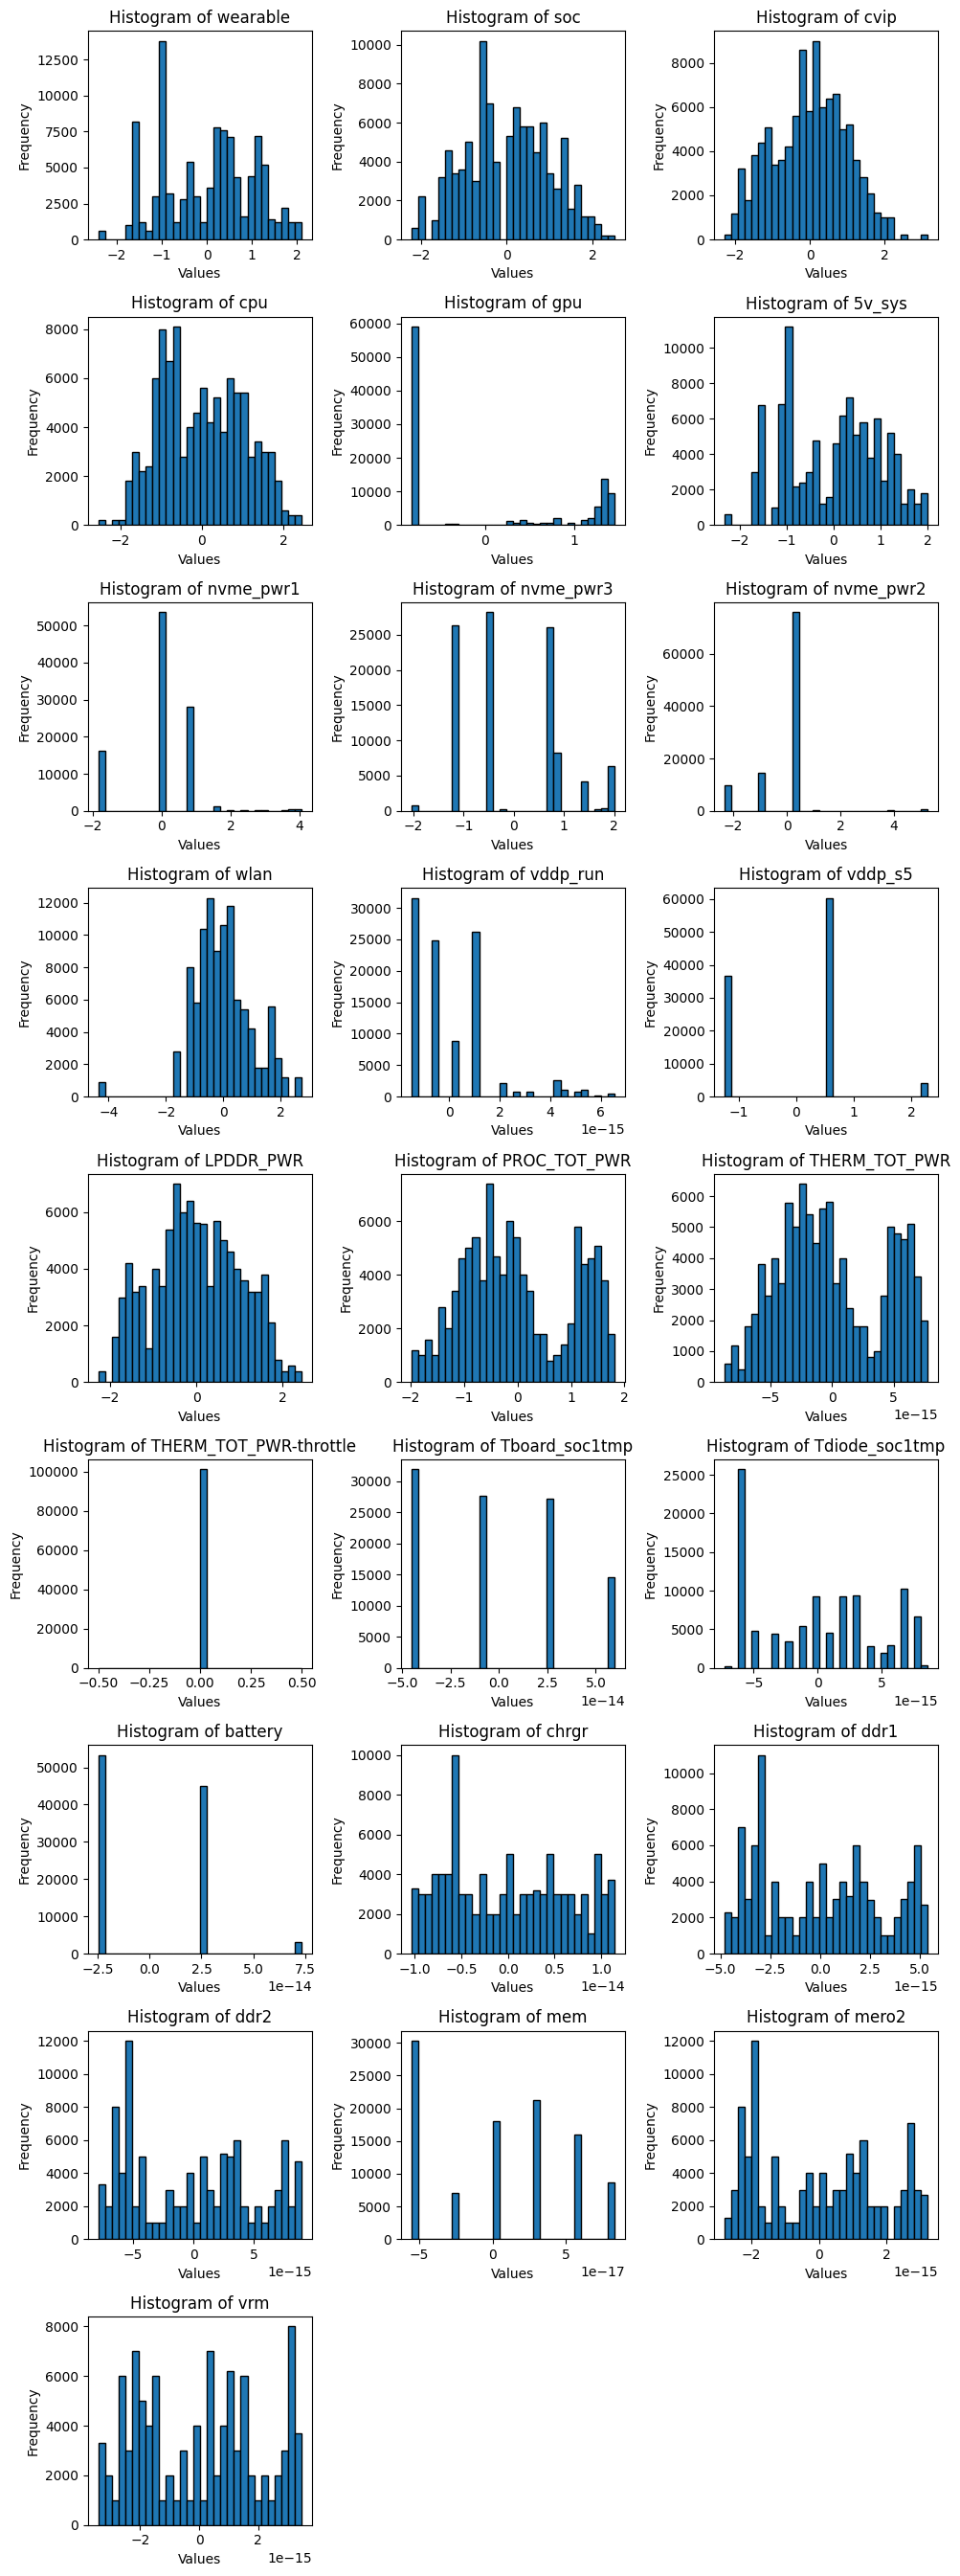

In [12]:
import matplotlib.pyplot as plt

num_columns = len(df_scaled.columns)
n_cols = 3  # Number of columns in the grid
n_rows = (num_columns // n_cols) + (num_columns % n_cols > 0)  
plt.figure(figsize=(10, 3 * n_rows))

for i, column in enumerate(df_scaled.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.hist(df_scaled[column].dropna(), bins=30, edgecolor='black')  
    plt.title(f'Histogram of {column}')
    plt.xlabel('Values')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


<Axes: xlabel='time'>

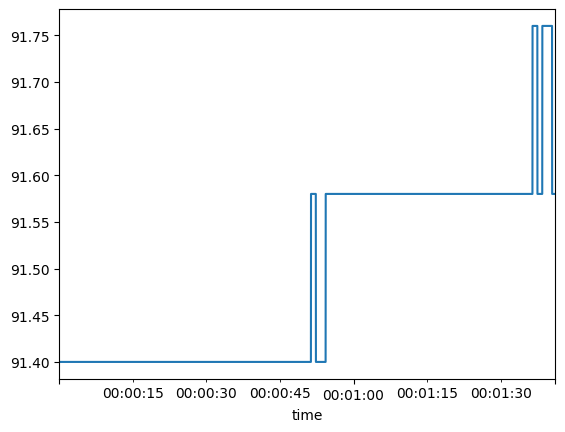

In [13]:
# just plot battery
df['battery'].plot()

Text(0.5, 0, 'Time')

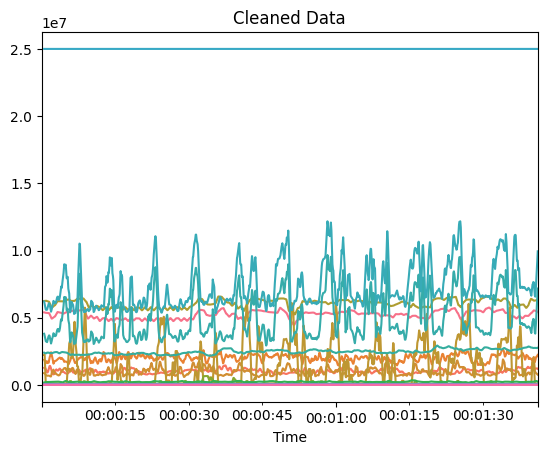

In [39]:
import seaborn as sns
# generate one color per column, evenly around the hue circle
palette = sns.color_palette('husl', n_colors=ma.shape[1])

# now pass it directly into pandas’ plot()
ax = ma.plot(color=palette, legend=False, title='Cleaned Data')
ax.set_xlabel('Time')



In [43]:
# Find column with largest average value in ma
column_averages = ma.mean()
largest_avg_column = column_averages.idxmax()
largest_avg_value = column_averages.max()

print(f"Column with largest average value: {largest_avg_column}")
print(f"Average value: {largest_avg_value}")

# Visualize the column averages
plt.figure(figsize=(10, 6))
column_averages.sort_values().plot(kind='bar')
plt.title('Average Values of Each Column')
plt.ylabel('Average Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

,wearable,soc,cvip,cpu,gpu,5v_sys,nvme_pwr1,nvme_pwr3,nvme_pwr2,wlan,...,THERM_TOT_PWR-throttle,Tboard_soc1tmp,Tdiode_soc1tmp,battery,chrgr,ddr1,ddr2,mem,mero2,vrm
time,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00.003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-01 00:00:00.004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-01 00:00:00.005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-01 00:00:00.006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-01 00:00:00.007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:01:41.199,5430840.0,1207026.0,2232988.0,766376.0,105000.0,6325938.0,14080.0,52544.0,11000.0,248856.0,...,25000000.0,123.8,120.9164,91.58,117.1616,122.45,120.7616,113.5616,123.4616,120.425
1970-01-01 00:01:41.200,5430560.0,1206758.0,2234174.0,766064.0,105000.0,6326092.0,14060.0,52458.0,11000.0,248704.0,...,25000000.0,123.8,120.9173,91.58,117.1616,122.45,120.7616,113.5616,123.4616,120.425
1970-01-01 00:01:41.201,5430280.0,1206490.0,2235360.0,765752.0,105000.0,6326246.0,14040.0,52372.0,11000.0,248552.0,...,25000000.0,123.8,120.9182,91.58,117.1616,122.45,120.7616,113.5616,123.4616,120.425


Text(0.5, 0, 'Time')

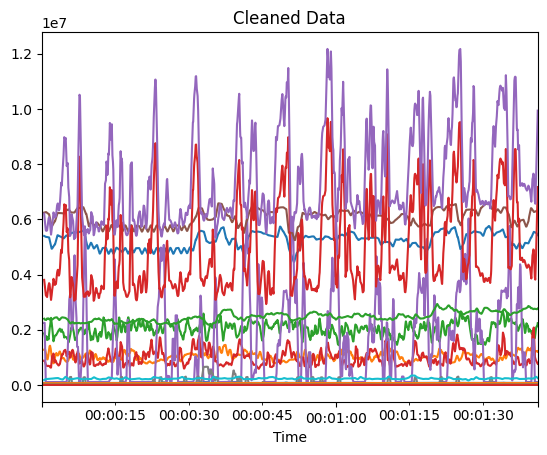

In [57]:
# remove the 'power' column
ma_no_power = ma.drop(columns=['THERM_TOT_PWR-throttle'])

# now plot
import seaborn as sns
palette = sns.color_palette('tab10', n_colors=ma_no_power.shape[1])
ax = ma_no_power.plot(color=palette, legend=False, title='Cleaned Data')
ax.set_xlabel('Time')


Text(0.5, 0, 'Time')

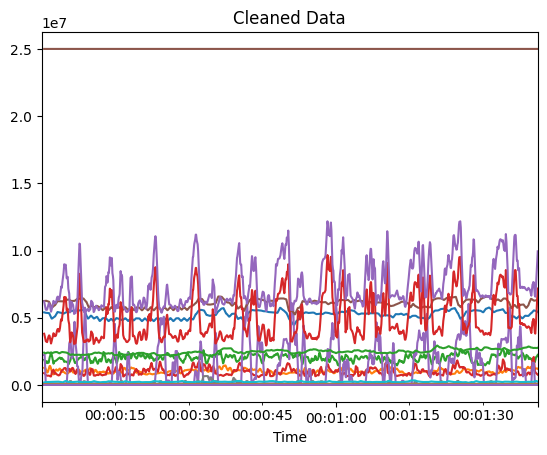

In [41]:
import seaborn as sns
# generate one color per column, evenly around the hue circle
palette = sns.color_palette('tab10', n_colors=ma.shape[1])

# now pass it directly into pandas’ plot()
ax = ma.plot(color=palette, legend=False, title='Cleaned Data')
ax.set_xlabel('Time')


<Axes: title={'center': 'Normalized'}, xlabel='time'>

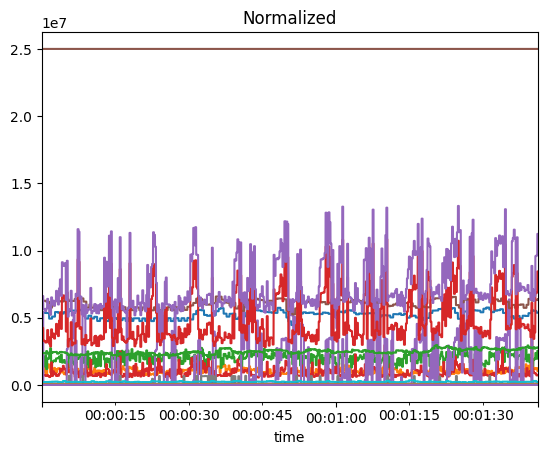

In [15]:
df.plot(legend=False, title='Normalized')

<Axes: >

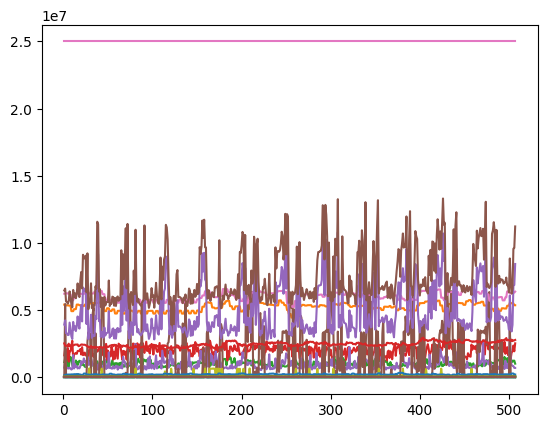

In [16]:
h1 = h1.drop(h1.index[0])
h1 = h1.apply(pd.to_numeric, errors='coerce')
h1.plot(legend=False)

In [17]:
h1

,time,wearable,soc,cvip,cpu,gpu,5v_sys,nvme_pwr1,nvme_pwr3,nvme_pwr2,...,THERM_TOT_PWR-throttle,Tboard_soc1tmp,Tdiode_soc1tmp,battery,chrgr,ddr1,ddr2,mem,mero2,vrm
1,0.003,5420000,1140000,1649000,731000,105000,6232000,79000,32000,11000,...,25000000,118.4,114.80,91.40,112.7750,117.0500,115.1366,110.4116,118.0616,115.250
2,0.204,5420000,1408000,2138000,1078000,5465000,6232000,10000,32000,11000,...,25000000,118.4,114.80,91.40,112.7750,117.0500,115.1366,110.4116,118.0616,115.250
3,0.402,5365000,1198000,1710000,751000,105000,6263000,20000,32000,11000,...,25000000,118.4,114.80,91.40,112.8866,117.1616,115.1366,110.4116,118.1750,115.250
4,0.602,5365000,1309000,1378000,740000,105000,6263000,10000,32000,11000,...,25000000,118.4,114.80,91.40,112.8866,117.1616,115.1366,110.4116,118.1750,115.250
5,0.802,5365000,914000,2194000,670000,105000,6263000,20000,32000,11000,...,25000000,118.4,114.80,91.40,112.8866,117.1616,115.1366,110.4116,118.1750,115.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,100.403,5514000,1287000,1853000,928000,105000,6267000,20000,35000,11000,...,25000000,123.8,120.65,91.76,117.1616,122.4500,120.6500,113.5616,123.3500,120.425
504,100.604,5514000,1162000,1948000,867000,105000,6311000,20000,78000,11000,...,25000000,123.8,120.65,91.58,117.1616,122.4500,120.7616,113.5616,123.4616,120.425
505,100.802,5514000,1251000,2375000,847000,105000,6311000,10000,35000,11000,...,25000000,123.8,121.10,91.58,117.1616,122.4500,120.7616,113.5616,123.4616,120.425
506,101.002,5374000,1251000,1948000,711000,105000,6311000,20000,78000,11000,...,25000000,123.8,120.65,91.58,117.1616,122.4500,120.7616,113.5616,123.4616,120.425
